In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from src.models.model import Net

from src.data.data_utils import load_train_test_ims, load_train_test_femto
from src.models.utils import test, calc_r2_avg, model_metrics_test, test_metrics_to_results_df
from src.models.loss import RMSELoss, RMSLELoss
import src.models.model
# from visualizations import plot_trained_model_results
from sklearn.metrics import r2_score

import h5py
from pathlib import Path

import fnmatch
import os
import shutil

from scipy.stats import pointbiserialr

%load_ext autoreload
%autoreload 2

from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# set the folder location of the temporary results
root_dir = Path.cwd().parent
print(root_dir)
temp_dir = root_dir / 'models/interim/results_csv_ims'

/home/tim/Documents/weibull-knowledge-informed


In [30]:
# make sure that the model.py is in the current notebook directory
# so that we can load the checkpoints
if Path(Path.cwd() / 'model.py').exists():
    pass
else:
    shutil.copy(root_dir / 'src/models/model.py', Path.cwd() / 'model.py')

In [25]:
# use multi-processing to load all the CSVs into one file
# https://stackoverflow.com/a/36590187
# wrap your csv importer in a function that can be mapped
def read_csv(filename):
    'converts a filename to a pandas dataframe'
    return pd.read_csv(filename)


def main(folder_path):

    # get a list of file names
    files = os.listdir(folder_path)
    file_list = [temp_dir / filename for filename in files if filename.endswith('.csv')]

    # set up your pool
    with Pool(processes=7) as pool: # or whatever your hardware can support

        # have your pool map the file names to dataframes
        df_list = pool.map(read_csv, file_list)

        # reduce the list of dataframes to a single dataframe
        combined_df = pd.concat(df_list, ignore_index=True)
        
        return combined_df
        

if __name__ == '__main__':
    df = main(temp_dir)
    
# drop first column
try:
    df = df.drop(columns='Unnamed: 0')
except:
    pass

# export combined dataframe
# csv sav_name
csv_save_name = 'combined_results_2021.04.05_1.csv'

# add a unique identifier for each model architecture
df['date_time_seed'] = df['date_time'].astype(str)+'_'+df['rnd_seed_input'].astype(str)

# get name that model checkpoint was saved under
df['model_checkpoint_name'] = df['date_time'].astype(str)+'_'+df['loss_func'] +'_'+df['rnd_seed_input'].astype(str)+'.pt'

# move 'date_time_seed' to front
# df = df[[list(df).pop()] + list(df)[:-1]]

df.to_csv(csv_save_name, index=False)
print('Final df shape:',df.shape)

#### append test results to df ####
ADD_TEST_RESULTS = True # True or False

if ADD_TEST_RESULTS:
    folder_path = root_dir / 'data/processed/IMS/'

    (
        x_train,
        y_train,
        x_val,
        y_val,
        x_test,
        y_test,
        x_train_2,
        y_train_2,
        x_train_3,
        y_train_3,
    ) = load_train_test_ims(folder_path)
    
    
#     (
#         x_train,
#         y_train,
#         x_val,
#         y_val,
#         x_test,
#         y_test,
#         x_train1_1,
#         y_train1_1,
#         x_train2_1,
#         y_train2_1,
#         x_train3_1,
#         y_train3_1,
#         x_val1_2,
#         y_val1_2,
#         x_val2_2,
#         y_val2_2,
#         x_val3_2,
#         y_val3_2,
#         x_test1_3,
#         y_test1_3,
#         x_test2_3,
#         y_test2_3,
#         x_test3_3,
#         y_test3_3,
#     ) = load_train_test_femto(folder_path)


    # load beta, eta for Weibull CDF
    with h5py.File(folder_path / "eta_beta_r.hdf5", "r") as f:
        eta_beta_r = f["eta_beta_r"][:]

    ETA = eta_beta_r[0]
    BETA = eta_beta_r[1]

    y_train_days = torch.reshape(y_train[:, 0], (-1, 1))
    y_val_days = torch.reshape(y_val[:, 0], (-1, 1))
    y_test_days = torch.reshape(y_test[:, 0], (-1, 1))

    y_train_days_2 = torch.reshape(y_train_2[:, 0], (-1, 1))
    y_train_days_3 = torch.reshape(y_train_3[:, 0], (-1, 1))


    y_train = torch.reshape(y_train[:, 1], (-1, 1))
    y_val = torch.reshape(y_val[:, 1], (-1, 1))
    y_test = torch.reshape(y_test[:, 1], (-1, 1))

    y_train_2 = torch.reshape(y_train_2[:, 1], (-1, 1))
    y_train_3 = torch.reshape(y_train_3[:, 1], (-1, 1))
    
    model_folder = root_dir / 'models/interim/checkpoints_ims/'
    print(model_folder)

    # append test results onto results dataframe
    df_results = test_metrics_to_results_df(model_folder, df, x_test, y_test)
    
    standard_losses = ['mse', 'rmse', 'rmsle']

    # apply 0 or 1 for weibull, and for each unique loss func
    for index, value in df_results['loss_func'].items():
        if value in standard_losses:
            df_results.loc[index, 'weibull_loss'] = 0
        else:
            df_results.loc[index, 'weibull_loss'] = 1

    # convert to 'weibull_loss' column to integer
    df_results['weibull_loss'] = df_results['weibull_loss'].astype(int)


    loss_func_list = df_results['loss_func'].unique()

    for index, value in df_results['loss_func'].items():
        for loss_func in loss_func_list:
            df_results.loc[index, value] = 1

    df_results[loss_func_list] = df_results[loss_func_list].fillna(0, downcast='infer')
    
    
    df_results.to_csv('combined_results_2021.04.05_1_with_test.csv', index=False)
    
clear_output(wait=True)
df.head()

,date_time,data_set,loss_func,rnd_seed_input,rnd_search_iter,rnd_search_iter_no,beta,eta,epochs,patience,...,loss_mse_val,loss_rmse_val,loss_mae_val,loss_rmsle_val,r2_val,r2_val_avg,r2_train_2_avg,r2_train_3_avg,date_time_seed,model_checkpoint_name
0,2021_04_05_12:13:49,ims,mse,2031227,3000,0,2.0,63.893981,2000,50,...,0.048042,0.219184,0.226290,0.154265,0.402568,0.427011,0.503176,0.091051,2021_04_05_12:13:49_2031227,2021_04_05_12:13:49_mse_2031227.pt
1,2021_04_05_12:13:49,ims,rmse,2031227,3000,0,2.0,63.893981,2000,50,...,0.052100,0.228253,0.222572,0.161700,0.352103,0.376099,0.612247,0.096594,2021_04_05_12:13:49_2031227,2021_04_05_12:13:49_rmse_2031227.pt
2,2021_04_05_12:13:49,ims,rmsle,2031227,3000,0,2.0,63.893981,2000,50,...,0.044224,0.210296,0.225933,0.148794,0.450040,0.483448,0.566187,0.075667,2021_04_05_12:13:49_2031227,2021_04_05_12:13:49_rmsle_2031227.pt
3,2021_04_05_12:13:49,ims,weibull_mse,2031227,3000,0,2.0,63.893981,2000,50,...,0.049331,0.222105,0.225896,0.154657,0.386536,0.407894,0.504709,0.093726,2021_04_05_12:13:49_2031227,2021_04_05_12:13:49_weibull_mse_2031227.pt
4,2021_04_05_12:13:49,ims,weibull_rmse,2031227,3000,0,2.0,63.893981,2000,50,...,0.044204,0.210248,0.225453,0.149279,0.450287,0.542401,0.522633,0.094508,2021_04_05_12:13:49_2031227,2021_04_05_12:13:49_weibull_rmse_2031227.pt


Define the metrics used to filter the results.

## Filter Results and Look at Top Performing

Filter the results by $R^2$, RMSE, and select top performing models from each batch of models. Chart.

In [31]:
# load csv
csv_save_name = 'combined_results_2021.04.05_1_with_test.csv'

# test adding the 0 or 1 for whether standard or Weibull loss functions
dfr = pd.read_csv(csv_save_name)

# how many unique model architectures?
print('No. unique model architectures:', len(dfr['date_time_seed'].unique()))
print('No. unique models (includes unique loss functions):', len(dfr['date_time_seed']))


No. unique model architectures: 1077
No. unique models (includes unique loss functions): 9375


In [32]:
# load csv
csv_save_name = 'combined_results_2021.04.05_1_with_test.csv'


# test adding the 0 or 1 for whether standard or Weibull loss functions
dfr = pd.read_csv(csv_save_name)

print('original dfr shape:', dfr.shape)

loss_func_list = dfr['loss_func'].unique()
# add filter
# tight filter
# r2_bound = 0.3 # greater than
# rmse_bound = 0.25 # less than

# looser filter
r2_bound = 0.2 # greater than
rmse_bound = 0.35 # less than

# even looser filter
# r2_bound = 0.0 # greater than
# rmse_bound = 1.0 # less than

# define what metric we'll use to evaulatate results
# sort_by = 'loss_rmse_test'
# sort_by = 'r2_val'
sort_by = 'r2_test'
# sort_by = 'r2_test_avg'

dfr = dfr[(dfr['r2_test']>r2_bound) & 
         (dfr['loss_rmse_test']<rmse_bound) &
         (dfr['r2_train']>r2_bound) &
         (dfr['loss_rmse_train']<rmse_bound) &
         (dfr['r2_val']>r2_bound) & 
         (dfr['loss_rmse_val']<rmse_bound) &
         (dfr['beta']==2.0)
][:]

print('shape of dfr before selecting top models in each architecture:', dfr.shape)

dfr = dfr.groupby(['date_time_seed']).apply(lambda x: x.sort_values([sort_by], ascending = False)).reset_index(drop=True)
dfr = dfr.groupby(['date_time_seed']).head(1).sort_values(by=sort_by, ascending=False)
# dfr = dfr.groupby(['date_time_seed', 'weibull_loss']).head(1).sort_values(by=sort_by, ascending=False)

# drop group if any models in the group did not train
# https://stackoverflow.com/a/34715183/9214620
# dfr = dfr.groupby(['date_time_seed']).filter(lambda x: x[sort_by].min() > 0.2)
dfr.to_csv('best_results_ims.csv', index=False)
print(dfr.shape)

original dfr shape: (9375, 48)
shape of dfr before selecting top models in each architecture: (3701, 48)
(775, 48)


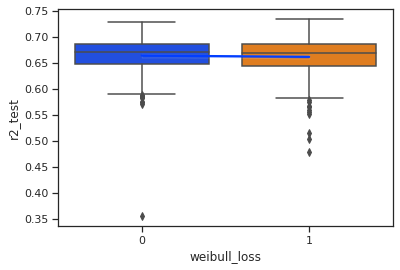

PointbiserialrResult(correlation=-0.03442282721059617, pvalue=0.33855322054102077)


In [33]:
sns.set(style="ticks",palette='bright')
ax = sns.boxplot(x=dfr['weibull_loss'], y=dfr[sort_by])
ax = sns.regplot(x=dfr['weibull_loss'], y=dfr[sort_by], scatter=False)
plt.show()

weibull_or_not = dfr['weibull_loss']
r2_test = dfr[sort_by]

pbc = pointbiserialr(weibull_or_not, r2_test)
print(pbc)

In [34]:
def change_loss_func_name(cols):
    loss_func = cols[0]
    
    if loss_func == 'mse':
        return 'MSE'
    elif loss_func == 'rmse':
        return 'RMSE'
    elif loss_func == 'rmsle':
        return 'RMSLE'
    elif loss_func == 'weibull_mse':
        return 'Weibull-MSE\nCombined'
    elif loss_func == 'weibull_rmse':
        return 'Weibull-RMSE\nCombined'
    elif loss_func == 'weibull_rmsle':
        return 'Weibull-RMSLE\nCombined'
    elif loss_func == 'weibull_only_mse':
        return 'Weibull Only MSE'
    elif loss_func == 'weibull_only_rmse':
        return 'Weibull Only RMSE'
    else:
        return 'Weibull Only RMLSE'    

df_count = dfr.groupby(['loss_func'], as_index=False).count()[['loss_func', 'date_time']].rename(columns={'date_time':'count'}).sort_values(by='count',ascending=False)
df_count['loss_func2'] = df_count[['loss_func']].apply(change_loss_func_name, axis=1)
df_count = df_count.drop('loss_func', axis=1)
df_count = df_count.rename(columns={'loss_func2':'loss_func'})
df_count['count'] = df_count['count'].astype(float)
df_count['percent'] = 100 * df_count['count'] / df_count['count'].sum()

df_count.to_csv('ims_count_results.csv', index=False)
df_count

,count,loss_func,percent
5,265.0,Weibull-RMSLE\nCombined,34.193548
2,213.0,RMSLE,27.483871
0,81.0,MSE,10.451613
1,79.0,RMSE,10.193548
3,76.0,Weibull-MSE\nCombined,9.806452
4,61.0,Weibull-RMSE\nCombined,7.870968


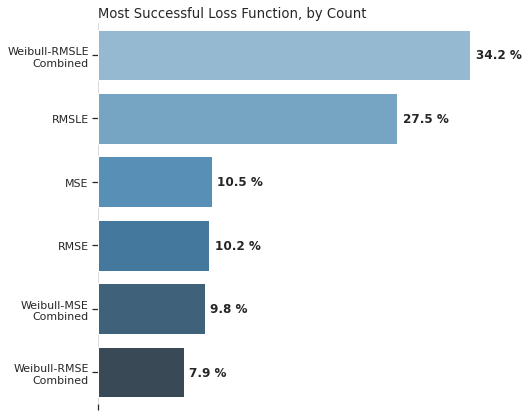

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7),)

sns.set(font_scale=1.1, style="whitegrid")
ax = sns.barplot(
    x="percent", y="loss_func", data=df_count, palette="Blues_d",
)
for p in ax.patches:
    # help from https://stackoverflow.com/a/56780852/9214620
    space = 0.5
    _x = p.get_x() + p.get_width() + float(space)
    _y = p.get_y() + p.get_height() / 2
    value = p.get_width()
    ax.text(_x, _y, f"{value:.1f} %", ha="left", va="center", weight="semibold", size=12)

ax.spines["bottom"].set_visible(True)
ax.set_ylabel("")
ax.set_xlabel("")
ax.grid(alpha=0.7, linewidth=1, axis="x")
ax.set_xticks([0])
ax.set_xticklabels([])
plt.title("Most Successful Loss Function, by Count", loc="left")

sns.despine(left=True, bottom=True)
# plt.savefig('loss_func_count_femto.png',dpi=600,bbox_inches = "tight")
plt.show()

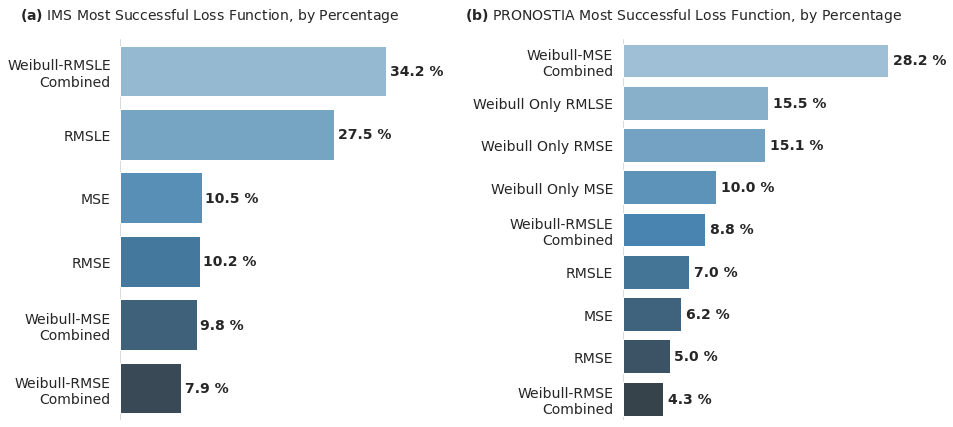

In [384]:
# chart showing both IMS and PRONOSTIA percentages
# load dataframes
ims_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.05_results_ims')
pron_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.07_results_femto')

ims_save_name = 'ims_count_results.csv'
pron_save_name = 'pronostia_count_results.csv'

# test adding the 0 or 1 for whether standard or Weibull loss functions
dfi = pd.read_csv(ims_folder / ims_save_name)
dfp = pd.read_csv(pron_folder / pron_save_name)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,7),)


title_list = [r"$\bf{(a)}$"+" IMS Most Successful Loss Function, by Percentage", 
              r"$\bf{(b)}$"+' PRONOSTIA Most Successful Loss Function, by Percentage']
df_list = [dfi, dfp]

sns.set(style="whitegrid", font="DejaVu Sans")
font_size = 14


for ax, df, title in zip(axes.flat, df_list, title_list):

    ax = sns.barplot(
        x="percent", y="loss_func", data=df, palette="Blues_d", ax=ax
    )

    for p in ax.patches:
        # help from https://stackoverflow.com/a/56780852/9214620
        space = 0.5
        _x = p.get_x() + p.get_width() + float(space)
        _y = p.get_y() + p.get_height() / 2
        value = p.get_width()
        ax.text(_x, _y, f"{value:.1f} %", ha="left", va="center", weight="semibold", size=font_size)

    ax.spines["bottom"].set_visible(True)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.grid(alpha=0.7, linewidth=1, axis="x")
    ax.set_xticks([0])
    ax.set_xticklabels([])
#     ax.text(-0.4, 1.06, title,
#     verticalalignment='top', horizontalalignment='left',
#     transform=ax.transAxes,
#     color='black', fontsize=12)
    
    ax.set_title(title, fontsize=font_size, loc='right')
    ax.tick_params(axis='y', labelsize=font_size)
    

plt.subplots_adjust(wspace=0.8)
sns.despine(left=True, bottom=True)
plt.savefig('loss_function_percentages.pdf',format='pdf', dpi=300, bbox_inches = "tight")
plt.show()

In [139]:
# Path("temp_pics/").mkdir(parents=True, exist_ok=True)
# cwd = Path.cwd()
# temp_path = Path("temp_pics/")

# for i, row in dfr.iterrows():
#     date_time = str(row['date_time'])
#     rnd_seed_input = str(row['rnd_seed_input']) 
# #     loss_func = str(row['loss_func'])
    
#     for file in os.listdir('learning_curves/'):
# #         if fnmatch.fnmatch(file, f'{date_time}_{loss_func}_{rnd_seed_input}.png'):
#         if fnmatch.fnmatch(file, f'{date_time}*{rnd_seed_input}.png'):
# #             print(file)
            
#             shutil.copy(cwd / 'learning_curves' / file, temp_path / file)

## Filter Results and Look Correlation

In [273]:
# load csv
csv_save_name = 'combined_results_2021.04.05_1_with_test.csv'

# test adding the 0 or 1 for whether standard or Weibull loss functions
dfr = pd.read_csv(csv_save_name)

# add filter
# tight filter
# r2_bound = 0.3 # greater than
# rmse_bound = 0.25 # less than

# looser filter
r2_bound = 0.2 # greater than
rmse_bound = 0.35 # less than

# even looser filter
# r2_bound = 0.0 # greater than
# rmse_bound = 1.0 # less than

# define what metric we'll use to evaulatate results
# sort_by = 'loss_rmse_test'
# sort_by = 'r2_val'
sort_by = 'r2_test'
# sort_by = 'r2_test_avg'


# dfr = dfr.groupby(['date_time_seed']).apply(lambda x: x.sort_values([sort_by], ascending = False)).reset_index(drop=True)
# dfr = dfr.groupby(['date_time_seed']).head(1).sort_values(by=sort_by, ascending=False)
# dfr = dfr.groupby(['date_time_seed', 'weibull_loss']).head(1).sort_values(by=sort_by, ascending=False)

dfr = dfr[(dfr['r2_test']>r2_bound) & 
         (dfr['loss_rmse_test']<rmse_bound) &
         (dfr['r2_train']>r2_bound) &
         (dfr['loss_rmse_train']<rmse_bound) &
         (dfr['r2_val']>r2_bound) & 
         (dfr['loss_rmse_val']<rmse_bound) &
         (dfr['beta']==2.0)
][:]

# drop group if any models in the group did not train
# https://stackoverflow.com/a/34715183/9214620
# dfr = dfr.groupby(['date_time_seed']).filter(lambda x: x[sort_by].min() > 0.2)
# dfr.to_csv('rmse_best_results.csv', index=False)
print(dfr.shape)

(3701, 48)


In [274]:
def change_loss_func_name(cols):
    loss_func = cols[0]
    
    if loss_func == 'mse':
        return 'MSE'
    elif loss_func == 'rmse':
        return 'RMSE'
    elif loss_func == 'rmsle':
        return 'RMSLE'
    elif loss_func == 'weibull_mse':
        return 'Weibull-MSE\nCombined'
    elif loss_func == 'weibull_rmse':
        return 'Weibull-RMSE\nCombined'
    elif loss_func == 'weibull_rmsle':
        return 'Weibull-RMSLE\nCombined'
    elif loss_func == 'weibull_only_mse':
        return 'Weibull Only\nMSE'
    elif loss_func == 'weibull_only_rmse':
        return 'Weibull Only\nRMSE'
    else:
        return 'Weibull Only\nRMLSE'    

df_c = dfr[list(loss_func_list) + [sort_by]].copy()

results = {}
for i in loss_func_list:
    results[i] = list(pointbiserialr(df_c[i], df_c[sort_by]))
    
df_r = pd.DataFrame.from_dict(results).T
df_r = df_r.rename(columns={0: 'corr', 1:'p_value'}).sort_values(by='corr').sort_values(by='corr',ascending=False)
df_r['loss_func2'] = df_r.index # reset index
df_r = df_r.reset_index(drop=True)
df_r['loss_func'] = df_r[['loss_func2']].apply(change_loss_func_name, axis=1)
df_r = df_r.drop('loss_func2', axis=1)
df_r.to_csv('ims_correlation_results.csv', index=False)
df_r

/home/tim/miniconda3/envs/torch1/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,corr,p_value,loss_func
0,0.128595,4.055943e-15,Weibull-RMSLE\nCombined
1,0.116674,1.080303e-12,RMSLE
2,-0.051611,1.684564e-03,MSE
3,-0.051827,1.610430e-03,RMSE
4,-0.059907,2.657731e-04,Weibull-RMSE\nCombined
5,-0.075221,4.625625e-06,Weibull-MSE\nCombined
6,NaN,NaN,Weibull Only\nMSE
7,NaN,NaN,Weibull Only\nRMSE
8,NaN,NaN,Weibull Only\nRMLSE


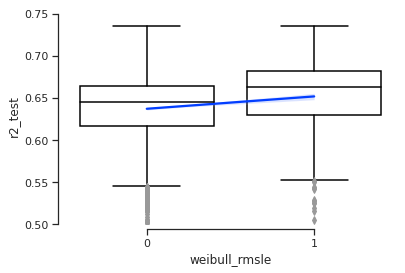

PointbiserialrResult(correlation=0.12859532106212954, pvalue=4.05594266292008e-15)


In [275]:
sort_by = 'r2_test'


sns.set(style="ticks",palette='bright')
ax = sns.boxplot(x=dfr['weibull_rmsle'], y=dfr[sort_by], color='white')


for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

    # iterate over whiskers and median lines
    for j in range(6*i,6*(i+1)):
         ax.lines[j].set_color('black')

ax = sns.regplot(x=dfr['weibull_rmsle'], y=dfr[sort_by], scatter=False)
            
plt.ylim(bottom=0.5)
sns.despine(offset=5, trim=True)
plt.show()

weibull_or_not = dfr['weibull_rmsle']
r2_test = dfr[sort_by]

pbc = pointbiserialr(weibull_or_not, r2_test)
print(pbc)

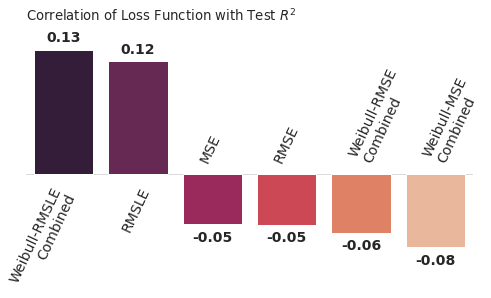

In [276]:
df_r = df_r.dropna(axis=0)
sns.set(font_scale=1.1, style="whitegrid")
f, ax = plt.subplots(1,1, figsize=(8,4))
ax = sns.barplot(x='loss_func',y='corr',ax=ax, palette='rocket', data=df_r)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# ax.axes.get_yaxis().set_visible(False) # hide y-axis
ax.grid(alpha=0.7, linewidth=1, axis="y")
ax.xaxis.set_label_text("",  size='large', weight='semibold')
ax.yaxis.set_label_text("", size='large', weight='semibold')
ax.set_yticks([0])
ax.set_yticklabels([], alpha=0)
ax.set_xticklabels([], alpha=0)
# plt.rc('xtick', labelsize='medium') 
# plt.rc('font', weight='semibold') 

for i, p in enumerate(ax.patches):
    # help from https://stackoverflow.com/a/56780852/9214620
    space = np.absolute(df_r['corr'].max()*0.1)

    value = p.get_height()
    if value >=0:
        _y = p.get_y() + p.get_height() + float(space)
        _x = p.get_x() + p.get_width() / 2
        ax.text(_x, _y, f"{value:.2f}", ha="center", va="center", weight="semibold", size=14)
#         ax.text(_x, -space, df_r['loss_func'][i], ha="center", va="top", weight="normal",multialignment='right', size=12, 
#                 rotation='vertical'
#                )
        ax.text(_x+0.2, -0.01, df_r['loss_func'][i], ha="right", va="top", weight="normal",multialignment='right', size=14, 
                rotation=65
               )

    else:
        _y = p.get_y() + p.get_height() - float(space)
        _x = p.get_x() + p.get_width() / 2
        ax.text(_x, _y, f"{value:.2f}", ha="center", va="center", weight="semibold", size=14)
        ax.text(_x-0.2, 0.01, df_r['loss_func'][i], ha="left", va="bottom", weight="normal",multialignment='left', size=14, 
                rotation=65
               )


plt.rcParams['axes.titlepad'] = 20
plt.title("Correlation of Loss Function with Test $R^2$", loc="left")
# plt.xlim(0,1)
# plt.ylim(-0.5,3.5)
plt.savefig('correlation_ims.png',dpi=300, bbox_inches = "tight")

plt.show()

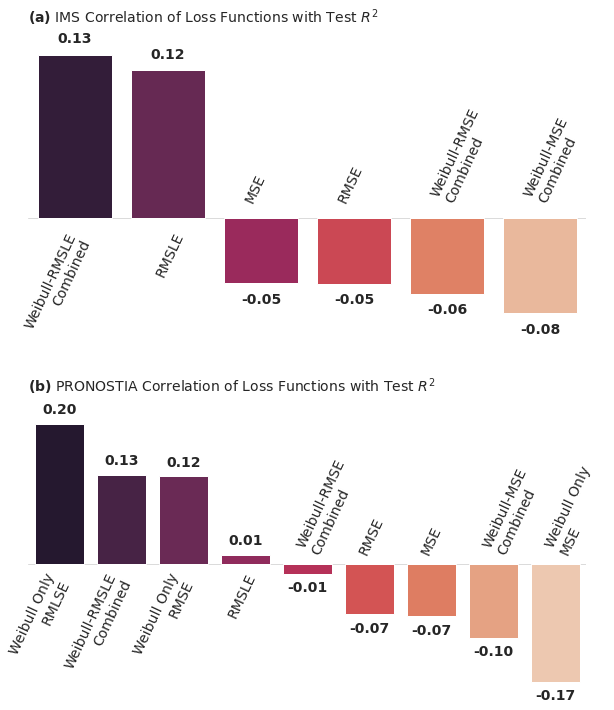

In [390]:
# chart showing both IMS and PRONOSTIA percentages
# load dataframes
ims_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.05_results_ims')
pron_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.07_results_femto')

ims_save_name = 'ims_correlation_results.csv'
pron_save_name = 'pronostia_correlation_results.csv'

# test adding the 0 or 1 for whether standard or Weibull loss functions
dfi = pd.read_csv(ims_folder / ims_save_name)
dfp = pd.read_csv(pron_folder / pron_save_name)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,12),)
sns.set(font_scale=1.1, style="whitegrid")

title_list = [r"$\bf{(a)}$"+" IMS Correlation of Loss Functions with Test $R^2$", 
              r"$\bf{(b)}$"+" PRONOSTIA Correlation of Loss Functions with Test $R^2$"]

df_list = [dfi, dfp]

for ax, df, title in zip(axes.flat, df_list, title_list):

    df = df.dropna(axis=0)
    
    ax = sns.barplot(x='loss_func',y='corr',ax=ax, palette='rocket', data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90,)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.axes.get_yaxis().set_visible(False) # hide y-axis
    ax.grid(alpha=0.7, linewidth=1, axis="y")
    ax.xaxis.set_label_text("",  size='large', weight='semibold')
    ax.yaxis.set_label_text("", size='large', weight='semibold')
    ax.set_yticks([0])
    ax.set_yticklabels([], alpha=0)
    ax.set_xticklabels([], alpha=0)
    # plt.rc('xtick', labelsize='medium') 
    # plt.rc('font', weight='semibold') 

    for i, p in enumerate(ax.patches):
        # help from https://stackoverflow.com/a/56780852/9214620
        space = np.absolute(df['corr'].max()*0.1)

        value = p.get_height()
        if value >=0:
            _y = p.get_y() + p.get_height() + float(space)
            _x = p.get_x() + p.get_width() / 2
            ax.text(_x, _y, f"{value:.2f}", ha="center", va="center", weight="semibold", size=14)
    #         ax.text(_x, -space, df_r['loss_func'][i], ha="center", va="top", weight="normal",multialignment='right', size=12, 
    #                 rotation='vertical'
    #                )
            ax.text(_x+0.2, -0.01, df['loss_func'][i], ha="right", va="top", weight="normal",multialignment='right', size=14, 
                    rotation=65
                   )

        else:
            _y = p.get_y() + p.get_height() - float(space)
            _x = p.get_x() + p.get_width() / 2
            ax.text(_x, _y, f"{value:.2f}", ha="center", va="center", weight="semibold", size=14)
            ax.text(_x-0.2, 0.01, df['loss_func'][i], ha="left", va="bottom", weight="normal",multialignment='left', size=14, 
                    rotation=65
                   )


    plt.rcParams['axes.titlepad'] = 20
    ax.set_title(title, loc="left", size=14)

plt.subplots_adjust(hspace=0.3)
plt.savefig('correlations.svg',dpi=300, format='svg', bbox_inches = "tight")
plt.show()

In [296]:
dfp

,corr,p_value,loss_func
0,0.197346,2.775707e-12,Weibull Only\nRMLSE
1,0.125986,9.194830e-06,Weibull-RMSLE\nCombined
2,0.123848,1.304108e-05,Weibull Only\nRMSE
3,0.012624,6.580168e-01,RMSLE
4,-0.013534,6.350949e-01,Weibull-RMSE\nCombined
5,-0.071192,1.243761e-02,RMSE
6,-0.073631,9.729005e-03,MSE
7,-0.103686,2.668589e-04,Weibull-MSE\nCombined
8,-0.166142,4.452417e-09,Weibull Only\nMSE


## Load Best Model and Check Test

In [12]:
folder_path = Path('/home/tim/Documents/bearing/data/processed/IMS')

(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
    x_train_2,
    y_train_2,
    x_train_3,
    y_train_3,
) = load_train_test(folder_path)


# load beta, eta for Weibull CDF
with h5py.File(folder_path / "eta_beta_r.hdf5", "r") as f:
    eta_beta_r = f["eta_beta_r"][:]

ETA = eta_beta_r[0]
BETA = eta_beta_r[1]

y_train_days = torch.reshape(y_train[:, 0], (-1, 1))
y_val_days = torch.reshape(y_val[:, 0], (-1, 1))
y_test_days = torch.reshape(y_test[:, 0], (-1, 1))

y_train_days_2 = torch.reshape(y_train_2[:, 0], (-1, 1))
y_train_days_3 = torch.reshape(y_train_3[:, 0], (-1, 1))


y_train = torch.reshape(y_train[:, 1], (-1, 1))
y_val = torch.reshape(y_val[:, 1], (-1, 1))
y_test = torch.reshape(y_test[:, 1], (-1, 1))

y_train_2 = torch.reshape(y_train_2[:, 1], (-1, 1))
y_train_3 = torch.reshape(y_train_3[:, 1], (-1, 1))

In [342]:
str(f"{df['lambda_mod'][model_index]:1f}")

'0.533660'

In [378]:
# load dataframes
ims_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.05_results_ims')
pron_folder = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.07_results_femto')

ims_save_name = 'best_results_ims.csv'
pron_save_name = 'best_results_pronostia.csv'

# load best results csv so that we can get the best model
df_ims = pd.read_csv(ims_folder / ims_save_name)
# should already be sorted, but make sure
df_ims = df_ims.sort_values(by='r2_test',ascending=False)

df_pron = pd.read_csv(pron_folder / pron_save_name)
df_pron = df_pron.sort_values(by='r2_test',ascending=False)


model_index = 0

df_all = pd.DataFrame()

for df, unit_data, date_mod in zip([df_ims, df_pron], ['days', 'hours'], [1, 24]):
    dfm = pd.DataFrame()
    dfm['Loss Function'] = [df['loss_func'][model_index]]
    dfm['Loss Function'] = dfm[['Loss Function']].apply(change_loss_func_name, axis=1)
    dfm['Layers'] = [df['n_layers'][model_index]]
    dfm['Units per Layer'] = [df['n_units'][model_index]]
    dfm['Drop Prob.'] = [df['prob_drop'][model_index]]
    dfm['λ'] = [f"{df['lambda_mod'][model_index]:.2f}"]
    dfm['β'] = [df['beta'][model_index]]
    dfm['η'] = [f"{df['eta'][model_index]*date_mod:.1f} {unit_data}"]
    
    
    df_all = df_all.append(dfm)


df_all = df_all.T
df_all.columns = ['IMS', 'PRONOSTIA']
df_all

,IMS,PRONOSTIA
Loss Function,Weibull-RMSE\nCombined,Weibull Only\nRMLSE
Layers,4,2
Units per Layer,32,32
Drop Prob.,0,0.25
λ,0.53,2.28
β,2,2
η,63.9 days,4.8 hours


In [380]:
print(df_all.to_latex())

\begin{tabular}{lll}
\toprule
{} &                     IMS &            PRONOSTIA \\
\midrule
Loss Function   &  Weibull-RMSE\textbackslash nCombined &  Weibull Only\textbackslash nRMLSE \\
Layers          &                       4 &                    2 \\
Units per Layer &                      32 &                   32 \\
Drop Prob.      &                       0 &                 0.25 \\
λ               &                    0.53 &                 2.28 \\
β               &                       2 &                    2 \\
η               &               63.9 days &            4.8 hours \\
\bottomrule
\end{tabular}



In [327]:
df['n_layers'][0]

4

In [385]:
# load best results csv so that we can get the best model
df_best = pd.read_csv('best_results_ims.csv')

# should already be sorted, but make sure
df_best = df_best.sort_values(by='r2_test',ascending=False)

# seclect top performing model and get the name it was saved under
model_name = df_best['model_checkpoint_name'][0]
print(model_name)

model_path = Path('/home/tim/Documents/bearing/notebooks/results_complete/2021.04.05_results_ims/checkpoints') / model_name

# select device to run neural net on
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")
    
criterion_mae = nn.L1Loss()
criterion_rmse = RMSELoss()
criterion_rmsle = RMSLELoss()

net = torch.load(model_path, map_location=device)

2021_04_05_17:06:26_weibull_rmse_3405377.pt
Running on CPU


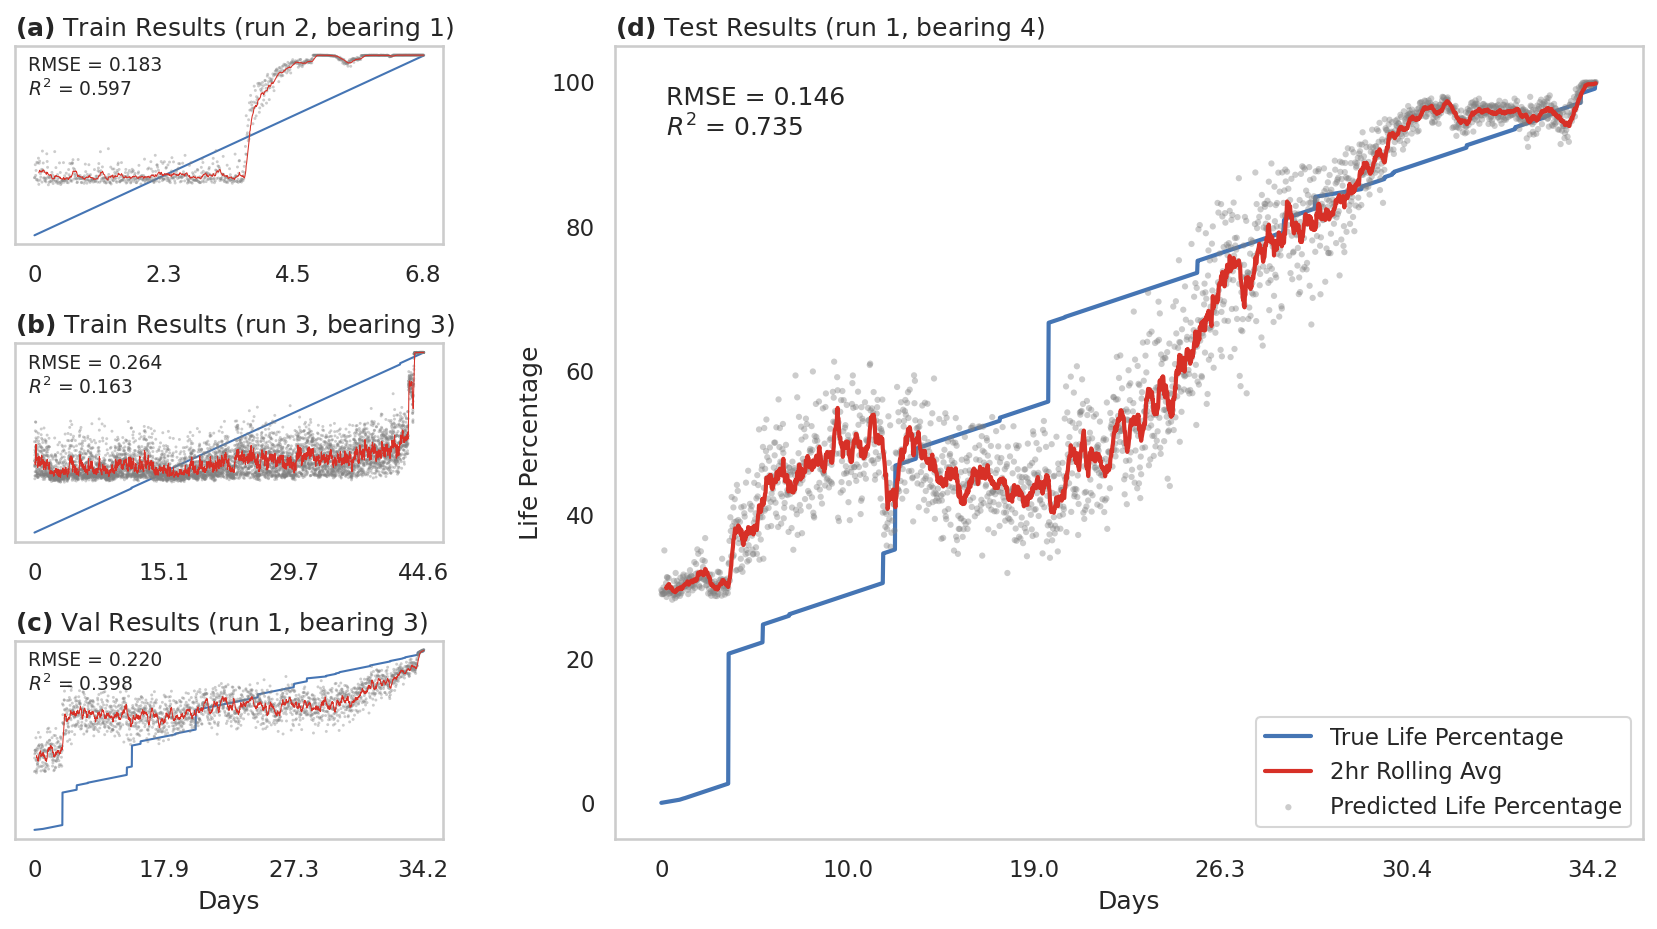

In [386]:
from matplotlib import gridspec
# from matplotlib import rc
# rc('text', usetex=True)


def calc_r2_avg(y_hats, y_val, index_sorted, window_size):
    y_hats_rolling_avg = np.convolve(np.array(y_hats[index_sorted]).reshape(-1), np.ones(window_size), 'valid') / window_size
    r2_val_avg = r2_score(np.array(y_val)[index_sorted][window_size-1:], y_hats_rolling_avg)
    return r2_val_avg, y_hats_rolling_avg




###### CREATE FIGURE #####
# color blind colors, from https://bit.ly/3qJ6LYL
# [#d73027, #fc8d59, #fee090, #4575b4]
# [redish, orangeish, yellowish, blueish]

sns.set(font_scale=1.0, style="whitegrid", )

# establish subplot axes
# helpful matplotlib guide: 
# https://matplotlib.org/2.0.2/users/gridspec.html
fig = plt.figure(figsize=(14, 7), dpi=150) 
gs = gridspec.GridSpec(3, 3)

# ax1 = plt.subplot(gs[:, :2])
# ax2 = plt.subplot(gs[0, 2])
# ax3 = plt.subplot(gs[1, 2])
# ax4 = plt.subplot(gs[2, 2])

ax1 = plt.subplot(gs[:, 1:])
ax2 = plt.subplot(gs[2, 0])
ax3 = plt.subplot(gs[0, 0])
ax4 = plt.subplot(gs[1, 0])
gs.update(wspace = 0.4, hspace = 0.5)


## General Formatting ##
# create list of axis elements
axes_list = [ax1, ax2, ax3, ax4]

for ax in axes_list:
    ax.grid(b=None)


###### TEST DATA #####
net.eval()

y_hats = test(net, x_test, device, 100)
index_sorted = np.array(np.argsort(y_test, 0).reshape(-1))

# build rolling average
window_size = 12 # 2 hour rolling avg
r2_test_avg, y_hats_rolling_avg = calc_r2_avg(y_hats, y_test, index_sorted, window_size)

loss_rmse_test = criterion_rmse(y_hats, y_test)
r2_test = r2_score(y_test, y_hats)
    
ax1.plot(np.array(y_test)[index_sorted]*100, label="True Life Percentage", alpha=1, color='#4575b4',linewidth=2, zorder=0)
ax1.scatter(
    np.arange(0, len(y_hats), 1),
    y_hats[index_sorted]*100,
    label="Predicted Life Percentage",
    alpha=0.4,
    c="grey",
    s=9, edgecolors='none',
)

ax1.plot(np.arange(0, len(y_hats), 1)[window_size-1:], y_hats_rolling_avg*100, 
        color='#d73027', alpha=1, label=f'{int(window_size/6)}hr Rolling Avg', linewidth=2, )

print_text = f"RMSE = {loss_rmse_test:.3f}\n$R^2$ = {r2_test:.3f}"

x_min, x_max = ax1.get_xlim()
y_min, y_max = ax1.get_ylim()

ax1.text(
    (x_max - x_min) * 0.05 + x_min,
    y_max - (y_max - y_min) * 0.05,
    print_text,
    fontsize=12,
    fontweight="normal",
    verticalalignment="top",
    horizontalalignment="left",
    bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
)

index_new = np.arange(0,len(y_hats),int(len(y_hats)/5)-1)

y_days_temp = np.array(y_test_days)
y_days_temp = np.reshape(y_days_temp, np.shape(y_days_temp)[0])[index_sorted]

labels_new = [f'{i:.1f}' for i in y_days_temp[index_new]]
# change first value to '0'
labels_new[0] = '0'

ax1.set_xticks(index_new)
ax1.set_xticklabels(labels_new)
ax1.set_xlabel("Days")
ax1.set_ylabel("Life Percentage")
ax1.legend(loc='lower right')


plt.rcParams['axes.titlepad'] =5
ax1.set_title(r"$\bf{(d)}$"+" Test Results (run 1, bearing 4)", loc="left")

# secondary axis title list
ax_title_list = [r"$\bf{(c)}$"+" Val Results (run 1, bearing 3)", 
                 r"$\bf{(a)}$"+" Train Results (run 2, bearing 1)", 
                 r"$\bf{(b)}$"+" Train Results (run 3, bearing 3)"]


# secondary axis counter
counter = 0
for ax, y_temp, x_temp, y_days, ax_title in zip([ax2,ax3,ax4],[y_val, y_train_2, y_train_3],
                            [x_val, x_train_2, x_train_3], [y_val_days, y_train_days_2, y_train_days_3], ax_title_list):
    
    y_hats = test(net, x_temp, device, 100)
    index_sorted = np.array(np.argsort(y_temp, 0).reshape(-1))

    # build rolling average
    window_size = 12 # 2 hour rolling avg
    r2_test_avg, y_hats_rolling_avg = calc_r2_avg(y_hats, y_temp, index_sorted, window_size)

    loss_rmse_test = criterion_rmse(y_hats, y_temp)
    r2_test = r2_score(y_temp, y_hats)

    ax.plot(np.array(y_temp)[index_sorted]*100, label="True Life Percentage", alpha=1, color='#4575b4',linewidth=1, zorder=0)
    ax.scatter(
        np.arange(0, len(y_hats), 1),
        y_hats[index_sorted]*100,
        label="Predicted Life Percentage",
        alpha=0.4,
        c="grey", edgecolors='none',
        s=2,
    )

    ax.plot(np.arange(0, len(y_hats), 1)[window_size-1:], y_hats_rolling_avg*100, 
            color='#d73027', alpha=1, label=f'{int(window_size/6)}hr Rolling Avg', linewidth=0.5)

    print_text = f"RMSE = {loss_rmse_test:.3f}\n$R^2$ = {r2_test:.3f}"

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.text(
        (x_max - x_min) * 0.03 + x_min,
        y_max - (y_max - y_min) * 0.05,
        print_text,
        fontsize=9,
        fontweight="normal",
        verticalalignment="top",
        horizontalalignment="left",
        bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
    )

    index_new = np.arange(0,len(y_hats),int(len(y_hats)/3)-1)

    y_days_temp = np.array(y_days)
    y_days_temp = np.reshape(y_days_temp, np.shape(y_days_temp)[0])[index_sorted]

    labels_new = [f'{i:.1f}' for i in y_days_temp[index_new]]
    # change first value to '0'
    labels_new[0] = '0'

    ax.set_xticks(index_new)
    ax.set_xticklabels(labels_new,)
    ax.set_yticklabels([])
    ax.set_title(ax_title, loc="left")
    
    if counter == 0:
        ax.set_xlabel("Days")
    
    counter += 1
    
# plt.savefig('ims_result_plot.png',dpi=150, bbox_inches = "tight")
plt.show()

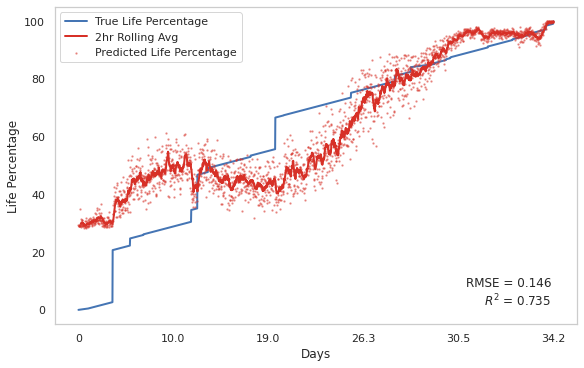

In [387]:
###### CALCULATE METRICS ON TEST DATA #####
net.eval()

y_hats = test(net, x_test, device, 100)
index_sorted = np.array(np.argsort(y_test, 0).reshape(-1))

def calc_r2_avg(y_hats, y_val, index_sorted, window_size):
    y_hats_rolling_avg = np.convolve(np.array(y_hats[index_sorted]).reshape(-1), np.ones(window_size), 'valid') / window_size
    r2_val_avg = r2_score(np.array(y_val)[index_sorted][window_size-1:], y_hats_rolling_avg)
    return r2_val_avg, y_hats_rolling_avg

# build rolling average
window_size = 12 # 2 hour rolling avg
r2_test_avg, y_hats_rolling_avg = calc_r2_avg(y_hats, y_test, index_sorted, window_size)

loss_rmse_test = criterion_rmse(y_hats, y_test)
# loss_mae_test = criterion_mae(y_hats, y_test)
# loss_rmsle_test = criterion_rmsle(y_hats, y_test)
r2_test = r2_score(y_test, y_hats)


###### CREATE FIGURE #####
# color blind colors, from https://bit.ly/3qJ6LYL
# [#d73027, #fc8d59, #fee090, #4575b4]
# [redish, orangeish, yellowish, blueish]
# ['mse', 'physics_loss', approx_constraint_loss, 'combined']
sns.set(font_scale=1.0, style="whitegrid")
fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True,)

ax.plot(np.array(y_test)[index_sorted]*100, label="True Life Percentage", alpha=1, color='#4575b4',linewidth=2, zorder=0)
ax.scatter(
    np.arange(0, len(y_hats), 1),
    y_hats[index_sorted]*100,
    label="Predicted Life Percentage",
    alpha=0.4,
    c="#d73027",
    s=2,
)

ax.plot(np.arange(0, len(y_hats), 1)[window_size-1:], y_hats_rolling_avg*100, 
        color='#d73027', alpha=1, label=f'{int(window_size/6)}hr Rolling Avg', linewidth=2)

print_text = f"RMSE = {loss_rmse_test:.3f}\n$R^2$ = {r2_test:.3f}"

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

ax.text(
    (x_max - x_min) * 0.95 + x_min,
    y_max - (y_max - y_min) * 0.90,
    print_text,
    fontsize=12,
    fontweight="normal",
    verticalalignment="center",
    horizontalalignment="right",
    bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
)



# ax.set_yticks(np.arange(1.5,20.5,2))

# labels = ax.get_xticklabels()
# loc = ax.get_xticks()
plt.grid(b=None)



index_new = np.arange(0,len(y_hats),int(len(y_hats)/5))

y_days_temp = np.array(y_test_days)
y_days_temp = np.reshape(y_days_temp, np.shape(y_days_temp)[0])[index_sorted]

labels_new = [f'{i:.1f}' for i in y_days_temp[index_new]]
# change first value to '0'
labels_new[0] = '0'

ax.set_xticks(index_new)
ax.set_xticklabels(labels_new)
ax.set_xlabel("Days")
ax.set_ylabel("Life Percentage")
ax.legend()  
plt.show()

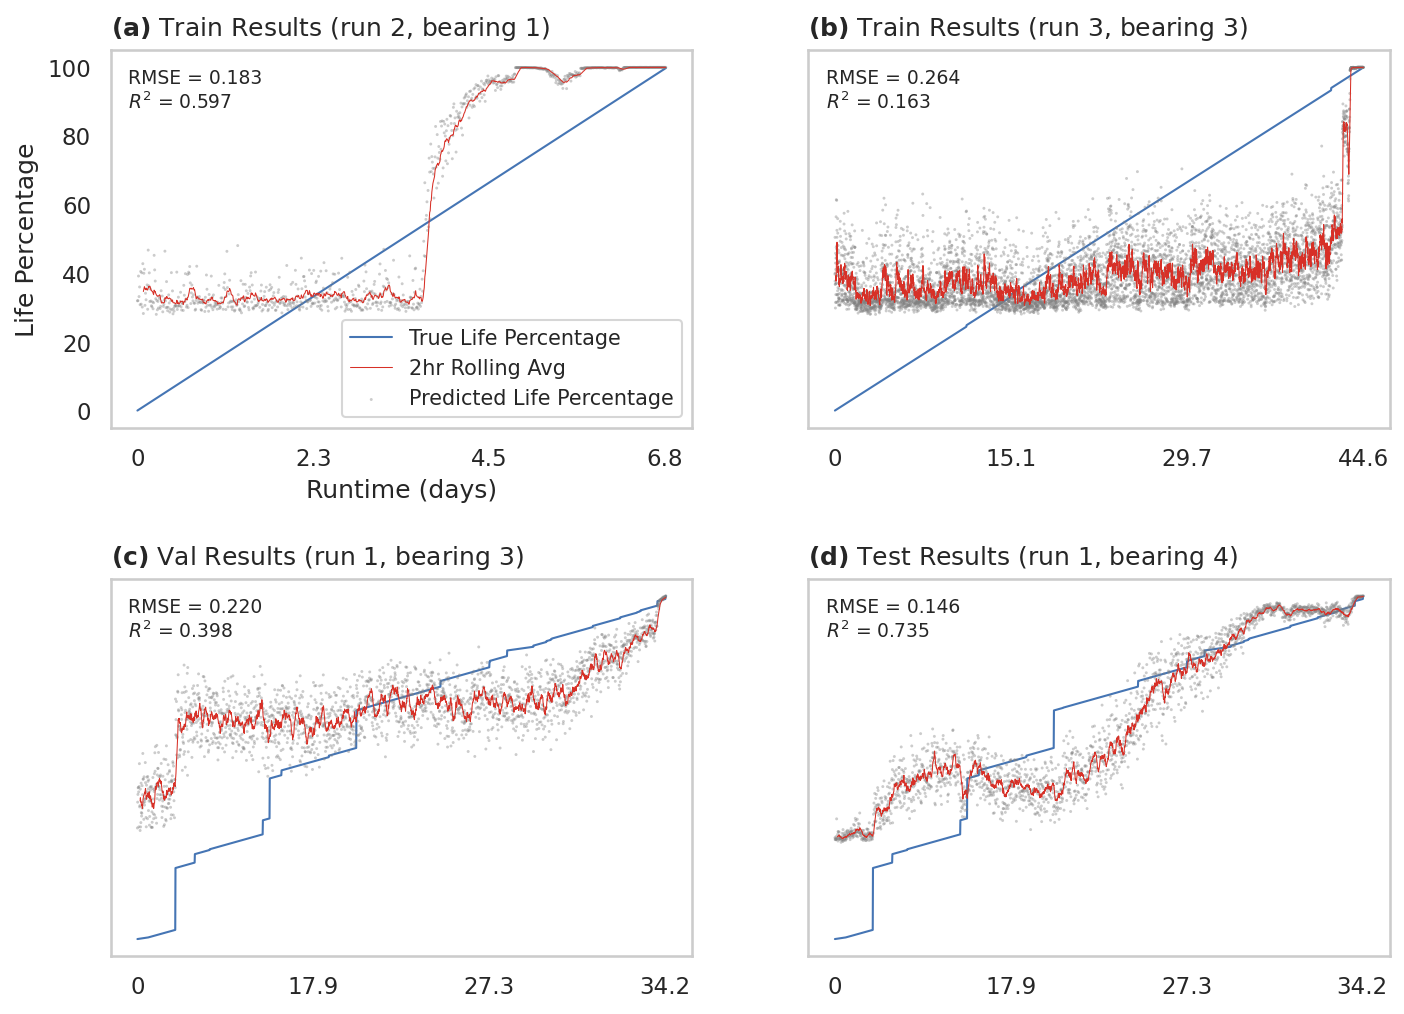

In [392]:
from matplotlib import gridspec
# from matplotlib import rc
# rc('text', usetex=True)


def calc_r2_avg(y_hats, y_val, index_sorted, window_size):
    y_hats_rolling_avg = np.convolve(np.array(y_hats[index_sorted]).reshape(-1), np.ones(window_size), 'valid') / window_size
    r2_val_avg = r2_score(np.array(y_val)[index_sorted][window_size-1:], y_hats_rolling_avg)
    return r2_val_avg, y_hats_rolling_avg




###### CREATE FIGURE #####
# color blind colors, from https://bit.ly/3qJ6LYL
# [#d73027, #fc8d59, #fee090, #4575b4]
# [redish, orangeish, yellowish, blueish]

sns.set(font_scale=1.0, style="whitegrid", )

# establish subplot axes
# helpful matplotlib guide: 
# https://matplotlib.org/2.0.2/users/gridspec.html
fig = plt.figure(figsize=(11, 8), dpi=150) 
gs = gridspec.GridSpec(2, 2)

# ax1 = plt.subplot(gs[:, :2])
# ax2 = plt.subplot(gs[0, 2])
# ax3 = plt.subplot(gs[1, 2])
# ax4 = plt.subplot(gs[2, 2])

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
gs.update(wspace = 0.2, hspace = 0.4)


## General Formatting ##
# create list of axis elements
axes_list = [ax1, ax2, ax3, ax4]

for ax in axes_list:
    ax.grid(b=None)

###### TEST DATA #####
net.eval()

plt.rcParams['axes.titlepad'] = 7

# secondary axis title list
ax_title_list = [ 
                 r"$\bf{(a)}$"+" Train Results (run 2, bearing 1)", 
                 r"$\bf{(b)}$"+" Train Results (run 3, bearing 3)",
                    r"$\bf{(c)}$"+" Val Results (run 1, bearing 3)",
                r"$\bf{(d)}$"+" Test Results (run 1, bearing 4)"]


# secondary axis counter
counter = 0
for ax, y_temp, x_temp, y_days, ax_title in zip([ax1, ax2,ax3,ax4],[y_train_2, y_train_3, y_val, y_test],
                            [x_train_2, x_train_3, x_val, x_test], [y_train_days_2, y_train_days_3, y_val_days, y_test_days], ax_title_list):
    
    y_hats = test(net, x_temp, device, 100)
    index_sorted = np.array(np.argsort(y_temp, 0).reshape(-1))

    # build rolling average
    window_size = 12 # 2 hour rolling avg
    r2_test_avg, y_hats_rolling_avg = calc_r2_avg(y_hats, y_temp, index_sorted, window_size)

    loss_rmse_test = criterion_rmse(y_hats, y_temp)
    r2_test = r2_score(y_temp, y_hats)

    ax.plot(np.array(y_temp)[index_sorted]*100, label="True Life Percentage", alpha=1, color='#4575b4',linewidth=1, zorder=0)
    ax.scatter(
        np.arange(0, len(y_hats), 1),
        y_hats[index_sorted]*100,
        label="Predicted Life Percentage",
        alpha=0.4,
        c="grey", edgecolors='none',
        s=2,
    )

    ax.plot(np.arange(0, len(y_hats), 1)[window_size-1:], y_hats_rolling_avg*100, 
            color='#d73027', alpha=1, label=f'{int(window_size/6)}hr Rolling Avg', linewidth=0.5)

    print_text = f"RMSE = {loss_rmse_test:.3f}\n$R^2$ = {r2_test:.3f}"

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    ax.text(
        (x_max - x_min) * 0.03 + x_min,
        y_max - (y_max - y_min) * 0.05,
        print_text,
        fontsize=9,
        fontweight="normal",
        verticalalignment="top",
        horizontalalignment="left",
        bbox={"facecolor": "gray", "alpha": 0.0, "pad": 6},
    )

    index_new = np.arange(0,len(y_hats),int(len(y_hats)/3)-1)

    y_days_temp = np.array(y_days)
    y_days_temp = np.reshape(y_days_temp, np.shape(y_days_temp)[0])[index_sorted]

    labels_new = [f'{i:.1f}' for i in y_days_temp[index_new]]
    # change first value to '0'
    labels_new[0] = '0'

    ax.set_xticks(index_new)
    ax.set_xticklabels(labels_new,)
#     ax.set_yticklabels([])
    ax.set_title(ax_title, loc="left")
    
    if counter == 0:
        ax.set_xlabel("Runtime (days)")
        ax.set_ylabel("Life Percentage")
        ax.legend(loc='lower right', fontsize=10)
        
    if counter !=0:
        ax.set_yticklabels([])
    
    counter += 1
    
# plt.savefig('ims_result_plot.svg',dpi=300, format='svg', bbox_inches = "tight")
plt.savefig('ims_result_plot.png',dpi=300, format='png', bbox_inches = "tight")
plt.show()

In [114]:
# y_list
y_list = [y_train_2, y_train_3, y_val, y_test]

# x_list
x_list = [x_train_2, x_train_3, x_val, x_test]

# y_days_list
y_days_list = [y_train_days_2, y_train_days_3, y_val_days, y_test_days]


val_max_list = [0.3, 0.4, 0.3, 
                0.5, 0.4, 0.4, 
                0.6, 0.8, 0.93]

color_scheme='inferno'

# vmax_x = 0
# for x in x_list:
#     print(torch.max(x).item())

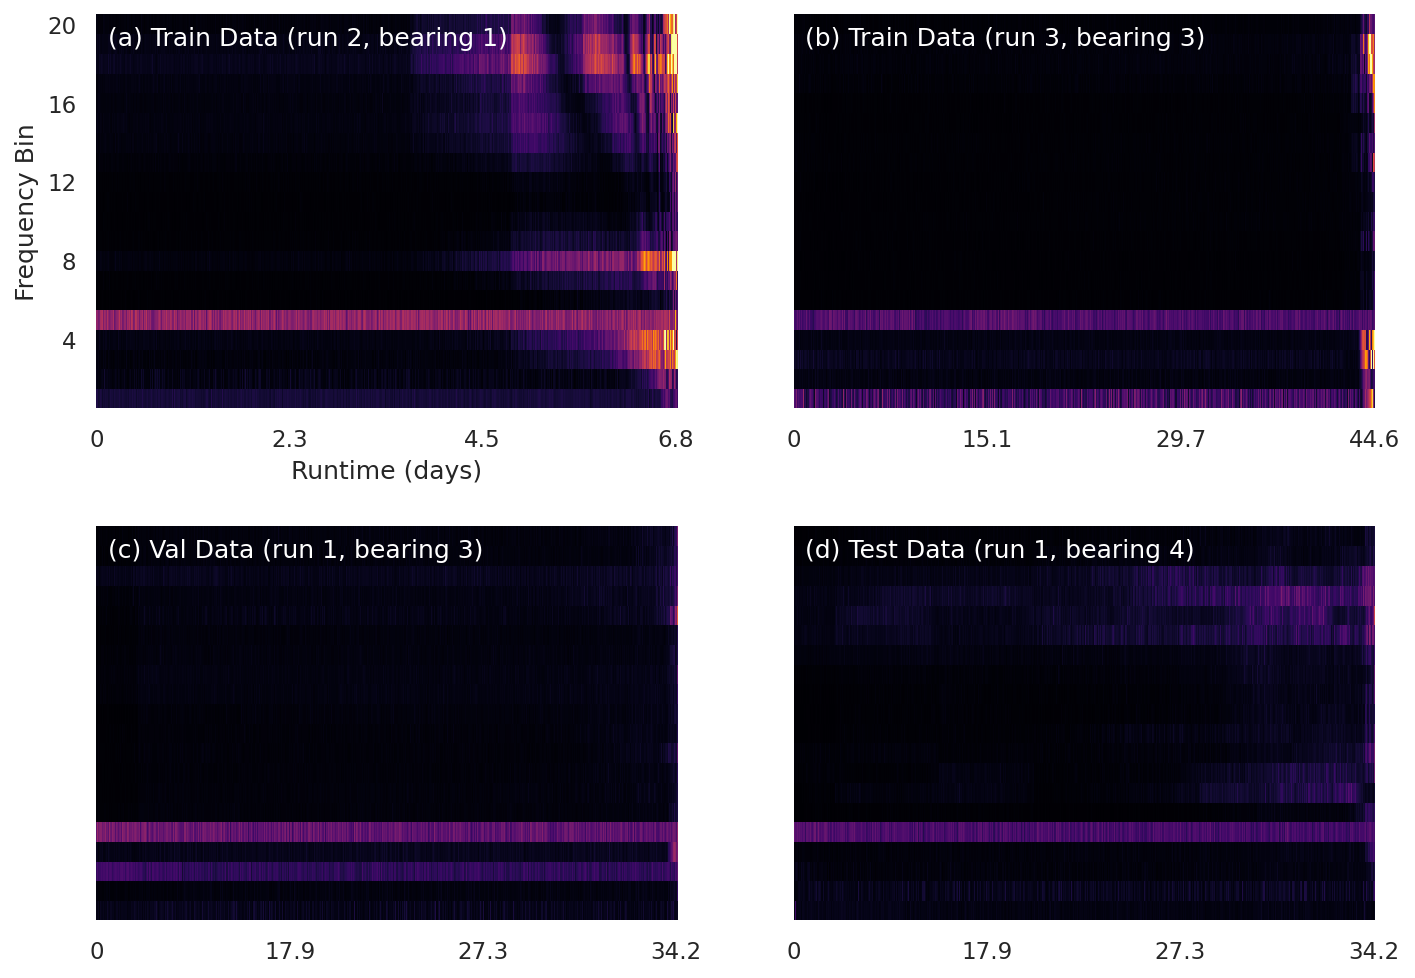

In [126]:
from matplotlib import gridspec
# from matplotlib import rc
# rc('text', usetex=True)


###### CREATE FIGURE #####

sns.set(font_scale=1.0, style="whitegrid", )

# establish subplot axes
# helpful matplotlib guide: 
# https://matplotlib.org/2.0.2/users/gridspec.html
fig = plt.figure(figsize=(11, 8), dpi=150) 
gs = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
gs.update(wspace = 0.2, hspace = 0.3)


## General Formatting ##
# create list of axis elements
axes_list = [ax1, ax2, ax3, ax4]

for ax in axes_list:
    ax.grid(b=None)

###### TEST DATA #####
net.eval()

plt.rcParams['axes.titlepad'] = 7

# secondary axis title list
ax_title_list = [ 
                "(a)"+" Train Data (run 2, bearing 1)", 
                 "(b)"+" Train Data (run 3, bearing 3)",
                    "(c)"+" Val Data (run 1, bearing 3)",
                "(d)"+" Test Data (run 1, bearing 4)"]


counter = 0
for ax, ax_title, y_temp, x_temp, y_days in zip(axes_list, ax_title_list, y_list, x_list, y_days_list):

    index_sorted = np.array(np.argsort(y_temp, 0).reshape(-1))
    
#     vmax_val = np.max(np.max(df_spec))*val_max_mod
    # create the time list that we'll use to label x-axis of spectrogram
#     time_list = []

#     for k in labels_dict:
#         time_list.append(labels_dict[k][-1])

    time_array = np.sort(y_days[:,-1])
    
    index_new = np.arange(0,len(time_array),int(len(time_array)/3)-1)
    
    labels_new = [f'{i:.1f}' for i in time_array[index_new]]
    # change first value to '0'
    labels_new[0] = '0'
    
    ax.pcolormesh(x_temp[index_sorted].T, 
                cmap=color_scheme,
                 vmax=0.5,
              )

    ax.set_xticks(index_new)
    ax.set_xticklabels(labels_new,)
    
    ax.text(0.02, 0.97, ax_title,
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes,
        color='white', fontsize=12)
    
    if counter == 0:
        ax.set_xticks(index_new)
        ax.set_xticklabels(labels_new,)
        ax.set_yticks(np.arange(3.5,20.5,4))
        ax.set_yticklabels(list(np.arange(4,21,4)))
        ax.set_ylabel('Frequency Bin')
        ax.set_xlabel('Runtime (days)')
    else:
        ax.set_yticklabels([])
        
    if counter !=0:
        ax.set_yticklabels([])
    
    
    
    counter += 1
    

    
sns.despine(left=True, bottom=True, right=True)
plt.savefig('spectrogram_processed_data_IMS.png',format='png', dpi=300, bbox_inches = "tight")
plt.show()